In [84]:
!mkdir /data/
!wget -P /data/ https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -n /data/Cat_Dog_data.zip -d /data

mkdir: cannot create directory ‘/data/’: File exists
--2020-06-09 09:54:31--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.13.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.13.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘/data/Cat_Dog_data.zip.1’

Cat_Dog_data.zip.1  100%[===================>] 553.60M  13.1MB/s    in 44s     

2020-06-09 09:55:17 (12.6 MB/s) - ‘/data/Cat_Dog_data.zip.1’ saved [580495262/580495262]

Archive:  /data/Cat_Dog_data.zip


In [0]:
# Importing the required library
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import os
import copy

In [0]:
# Transforming and loading the datasets
data_transform = {
                  'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])]),
                  'test' : transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])])
                  }

datadir = '/data/Cat_Dog_data/'
batch_size=32

image_datasets = {x: datasets.ImageFolder(os.path.join(datadir,x),
                                          transform=data_transform[x]) 
                  for x in ['train', 'test']}
data_loader = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
classes = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

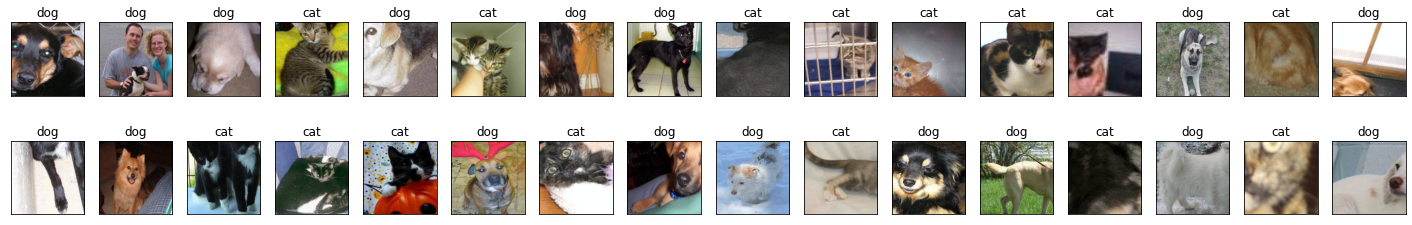

In [77]:
#Visualize the training data
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, batch_size, title_classes=None, title_preds=None):
    """Imshow for Tensor."""

    image = inp.numpy()
    fig = plt.figure(figsize=(25,4))
    for idx in range(batch_size):
        img = image[idx].transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax = plt.subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
        ax.imshow(img)
        if title_classes is not None:
            ax.set_title(title_classes[idx])
        if title_classes and title_preds is not None:
            ax.set_title("{} ({})".format(title_preds[idx], title_classes[idx]),
                    color=("green" if title_preds[idx]==title_classes[idx] else "red"))
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, labels = next(iter(data_loader['train']))

# Display a batch of images
imshow(images, batch_size, title_classes=[classes[x] for x in labels])

In [0]:
# Importing libraries for training process
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        start_epoch = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            elapsed_epoch = time.time() - start_epoch
            print('Time needed per epoch : {:.4f}m {:.0f}s'.format(
                  elapsed_epoch // 60, elapsed_epoch % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    model.eval()

    with torch.no_grad():
        inputs, labels = next(iter(data_loader['test']))
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        imshow(inputs.cpu().data, batch_size=32, 
               title_classes = [classes[x] for x in labels], 
               title_preds = [classes[x] for x in preds])


In [51]:
# Load the pretrained model

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [58]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.1081 Acc: 0.9537
Time needed per epoch : 1.0000m 48s
test Loss: 0.0291 Acc: 0.9876
Time needed per epoch : 1.0000m 60s

Epoch 2/25
----------
train Loss: 0.0965 Acc: 0.9597
Time needed per epoch : 1.0000m 50s
test Loss: 0.0277 Acc: 0.9888
Time needed per epoch : 2.0000m 2s

Epoch 3/25
----------
train Loss: 0.0905 Acc: 0.9640
Time needed per epoch : 1.0000m 51s
test Loss: 0.0255 Acc: 0.9892
Time needed per epoch : 2.0000m 3s

Epoch 4/25
----------
train Loss: 0.0869 Acc: 0.9629
Time needed per epoch : 1.0000m 50s
test Loss: 0.0303 Acc: 0.9860
Time needed per epoch : 2.0000m 2s

Epoch 5/25
----------
train Loss: 0.0779 Acc: 0.9674
Time needed per epoch : 1.0000m 50s
test Loss: 0.0254 Acc: 0.9880
Time needed per epoch : 2.0000m 2s

Epoch 6/25
----------
train Loss: 0.0754 Acc: 0.9684
Time needed per epoch : 1.0000m 50s
test Loss: 0.0289 Acc: 0.9884
Time needed per epoch : 2.0000m 2s

Epoch 7/25
----------
train Loss: 0.0738 Acc: 0.9688
Time needed per 

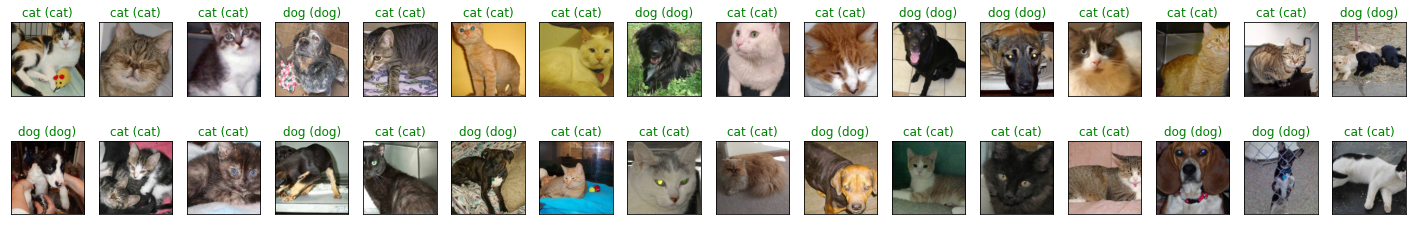

In [83]:
visualize_model(model_ft)

plt.show()